# Testing

---
Stuff that i dont want to confuse in the Main

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import random
import os

import torch

In [2]:
ROOT_PATH = Path("..")  

AUDIO_DIR = ROOT_PATH / "Data" / "Audio"
ANNOT_DIR = ROOT_PATH / "Data" / "Annotations"
SPECT_DIR = ROOT_PATH / "Data" / "Spectrograms"

ANNOT_FILE = ANNOT_DIR / "audio_annotations.csv"

train_df = pd.read_csv(ANNOT_DIR / "train.csv")
val_df   = pd.read_csv(ANNOT_DIR / "val.csv")
test_df  = pd.read_csv(ANNOT_DIR / "test.csv")

import sys
project_root = ROOT_PATH
sys.path.append(str(project_root))

## Code

KillerWhale ---  shape: (1, 128, 425)
KillerWhale ---  shape: (1, 128, 395)
StripedDolphin ---  shape: (1, 128, 154)


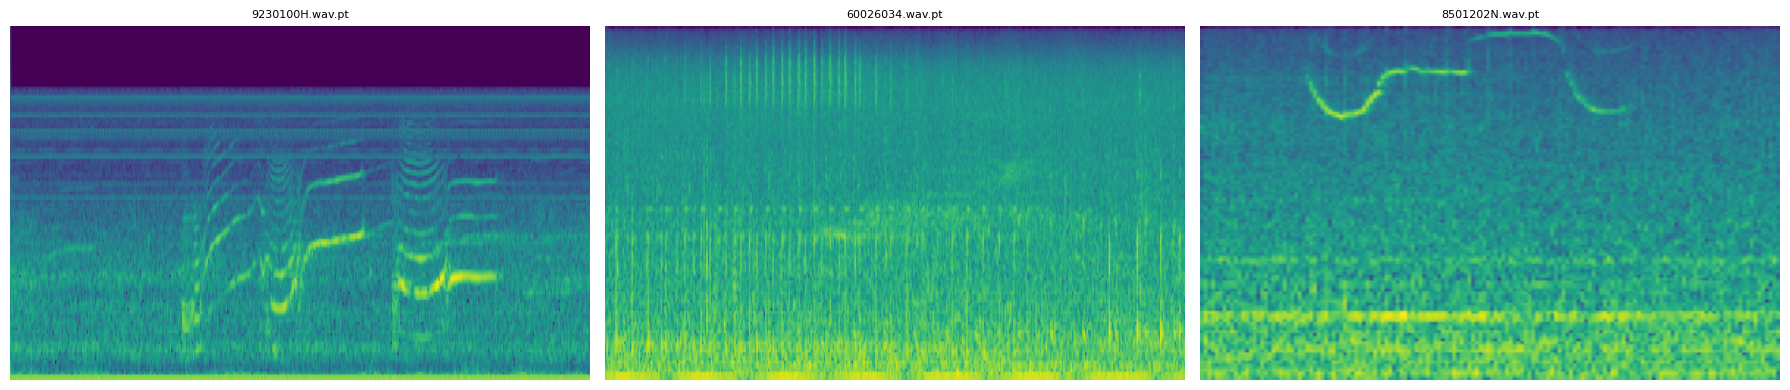

In [3]:
base_dir = ROOT_PATH / "Data" / "Spectrograms" / "train"

all_files = []
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.endswith(".pt"):
            relative_path = os.path.join(root, f)
            all_files.append(relative_path)

if len(all_files) < 3:
    raise ValueError("Not enough .pt files found.")

# Select 3 random spectrograms
samples = random.sample(all_files, 3)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, path in zip(axes, samples):
    tensor = torch.load(path)

    species_name = os.path.basename(os.path.dirname(path))
    # Print the tensor shape and name
    print(f"{species_name} ---  shape: {tuple(tensor.shape)}")

    # Convert tensor to 2D for plotting
    if tensor.dim() == 2:
        img = tensor
    elif tensor.dim() == 3:
        # assume [C, H, W]
        img = tensor[0]  
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

    ax.imshow(img.numpy(), aspect="auto", origin="lower", cmap="viridis")
    ax.set_title(os.path.basename(path), fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Testing basic cnn

In [ ]:
import torch
from src.baseline_cnn import BaselineCNN
from src.dataloaders import train_loader

# Get one batch from the dataloader
x, y = next(iter(train_loader))

print("Input batch shape:", x.shape)
print("Labels shape:", y.shape)

# Create model
model = BaselineCNN(input_channels=1, num_classes=2)

# Run forward pass
with torch.no_grad():
    out = model(x)

print("Output shape:", out.shape)
print("Output:", out)

Input batch shape: torch.Size([16, 1, 128, 400])
Labels shape: torch.Size([16])
Output shape: torch.Size([16, 2])
Output: tensor([[ 0.1199,  0.0153],
        [ 0.1190, -0.0125],
        [ 0.1332,  0.0164],
        [ 0.1207,  0.0239],
        [ 0.1189,  0.0300],
        [ 0.1608, -0.0344],
        [ 0.1433,  0.0124],
        [ 0.1099, -0.0077],
        [ 0.0995,  0.0247],
        [ 0.1395, -0.0257],
        [ 0.1290,  0.0088],
        [ 0.1338,  0.0110],
        [ 0.1900, -0.0423],
        [ 0.1073,  0.0226],
        [ 0.1552, -0.0204],
        [ 0.1326,  0.0150]])
tensor([[0.5261, 0.4739],
        [0.5328, 0.4672],
        [0.5292, 0.4708],
        [0.5242, 0.4758],
        [0.5222, 0.4778],
        [0.5487, 0.4513],
        [0.5327, 0.4673],
        [0.5294, 0.4706],
        [0.5187, 0.4813],
        [0.5412, 0.4588],
        [0.5300, 0.4700],
        [0.5307, 0.4693],
        [0.5578, 0.4422],
        [0.5212, 0.4788],
        [0.5438, 0.4562],
        [0.5294, 0.4706]])


**For Human-readable probabilities:**

In [7]:
probs = torch.softmax(out, dim=1)
print(probs)

tensor([[0.5261, 0.4739],
        [0.5328, 0.4672],
        [0.5292, 0.4708],
        [0.5242, 0.4758],
        [0.5222, 0.4778],
        [0.5487, 0.4513],
        [0.5327, 0.4673],
        [0.5294, 0.4706],
        [0.5187, 0.4813],
        [0.5412, 0.4588],
        [0.5300, 0.4700],
        [0.5307, 0.4693],
        [0.5578, 0.4422],
        [0.5212, 0.4788],
        [0.5438, 0.4562],
        [0.5294, 0.4706]])


*Note: example: [-0.1171, -0.0087]*
- *Score for class 0: -0.1171*
- *Score for class 1: -0.0087*

*The class with the higher logit is the predicted class.*
- *Here: -0.0087 > -0.1171 → predict class 1.*

*We have 16 predictions (16 x 2 matrix)*